# 實驗2: One 2d Gaussian SDE and ODE 

1D SDE: 
$$
dX_t = -\beta X_t dt+\sigma dW_t.
$$

Then 2D SDE:
$$
d\textbf{X}_t=-B\textbf{X}_tdt+\Sigma d\textbf{W}_t,
$$
where 
* $\textbf{X}_t=(X^{(1)}_t, X_t^{(2)})^{T}$
* $B:=\beta I$ is an $2\times 2$ drift matrix
* $\Sigma$ is an $2\times 2$ noise matrix

對OU process來說, 2D就變成

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def SDE_forward_2d(beta, sigma, rng,
                   T, dt,
                   mu0, C0,
                   K_traj, N):
    """
    二維 OU forward SDE + 畫圖（都包在這個函數裡）

    beta   : drift rate
    sigma  : noise amplitude
    rng    : np.random.Generator
    T      : 終止時間
    dt     : 步長
    mu0    : 初始 mean，shape = (2,)
    C0     : 初始 covariance，shape = (2,2)
    K_traj : 要畫的軌跡條數（從 N 個 sample 裡選前 K_traj 個）
    N      : sample 數目
    """

    # ------- 內部畫圖函數 -------
    def plot_2d(traj_hist, times, mu0):
        """
        traj_hist: shape = (S, K, 2)  # S 個時間截面、K 條軌跡
        times    : shape = (S,)
        """
        S, K, _ = traj_hist.shape

        fig, ax = plt.subplots(figsize=(5,5))

        # 畫每一條 2D 軌跡
        for j in range(K):
            ax.plot(traj_hist[:, j, 0],
                    traj_hist[:, j, 1],
                    linewidth=1.0, alpha=0.8)

        # 標一下初始點（t=0）與終點（t=T）
        start_pts = traj_hist[0]      # (K,2)
        end_pts   = traj_hist[-1]     # (K,2)
        ax.scatter(start_pts[:,0], start_pts[:,1],
                   s=30, marker="o", edgecolor="k", facecolor="none",
                   label="t=0")
        ax.scatter(end_pts[:,0], end_pts[:,1],
                   s=20, marker="x", color="red",
                   label=f"t={times[-1]:.2f}")

        # 標一下初始 mean 位置
        ax.scatter(mu0[0], mu0[1],
                   s=60, marker="*", color="gold", edgecolor="k",
                   label="mu0")

        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_title("2D Forward OU SDE Trajectories")
        ax.axis("equal")
        ax.grid(alpha=0.3)
        ax.legend(loc="best")
        plt.tight_layout()
        plt.show()

    # ------- SDE 模擬本體 -------
    steps = int(T/dt)

    # 初始 (N,2) 樣本：X_0 ~ N(mu0, C0)
    x = rng.multivariate_normal(mu0, C0, size=N)   # shape = (N,2)

    traj_hist = [x[:K_traj].copy()]   # 只記前 K_traj 條軌跡
    times = [0.0]

    for i in range(1, steps+1):
        dW = rng.normal(size=(N,2)) * np.sqrt(dt)

        # drift = -beta * x  (逐點作用)
        x = x + (-beta * x) * dt + sigma * dW

        t = i * dt
        if i % max(1, steps//300) == 0:
            traj_hist.append(x[:K_traj].copy())
            times.append(t)

    traj_hist = np.array(traj_hist)   # (S, K, 2)
    times = np.array(times)           # (S,)

    # 呼叫內部畫圖函數
    plot_2d(traj_hist, times, mu0)

    # 也把資料回傳，之後想再畫別的圖還可以用
    return traj_hist, times


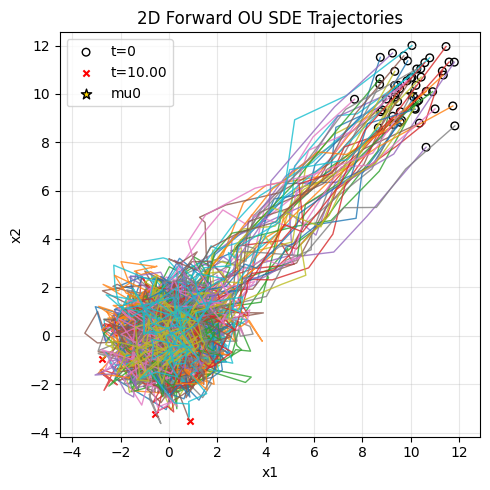

In [17]:
rng = np.random.default_rng(0)

beta  = 2.0
sigma = 2.0
mu0   = np.array([10.0, 10.0])
C0    = np.eye(2) * 1.0

T     = 10.0
dt    = 0.1
K_traj = 50
N      = 5000

traj_hist, times = SDE_forward_2d(beta, sigma, rng,
                                  T, dt,
                                  mu0, C0,
                                  K_traj, N)


---

加加看有動畫的

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

def simulate_ou_2d(beta, sigma, rng,
                   T_max, dt,
                   mu0, C0,
                   N):
    """
    模擬 2D OU，回傳：
    times: shape (S,)  所有時間點
    X_snap: shape (S, N, 2) 每個時間的 N 個樣本
    這裡我們會只保留「整數秒」的 snapshot。
    """
    steps = int(T_max / dt)
    times_full = np.linspace(0, T_max, steps+1)

    # 存所有步的樣本（中間用來 subsample）
    X_full = np.empty((steps+1, N, 2))
    x = rng.multivariate_normal(mu0, C0, size=N)
    X_full[0] = x

    for k in range(1, steps+1):
        dW = rng.normal(size=(N,2)) * np.sqrt(dt)
        x = x + (-beta * x) * dt + sigma * dW   # 標準 OU: 往 0 拉
        X_full[k] = x

    # 只取「整數秒」的時間點（0,1,2,...,T_max）
    int_times = np.arange(0, int(T_max)+1)
    idx = (int_times / dt).astype(int)   # 對應到 full grid 的 index
    X_snap = X_full[idx]                 # shape = (S, N, 2)

    return int_times, X_snap


In [19]:
def interactive_ou_2d(beta=1.0, sigma=0.5,
                      T_max=10.0, dt=0.01,
                      mu0=np.array([0.0, 0.0]),
                      C0=np.eye(2),
                      N=2000,
                      seed=0):

    rng = np.random.default_rng(seed)

    # 先模擬
    times, X_snap = simulate_ou_2d(beta, sigma, rng,
                                   T_max, dt,
                                   mu0, C0, N)

    # 初始時間 index = 0 (t = 0)
    t0_idx = 0
    X0 = X_snap[t0_idx]

    # 建立圖
    fig, ax = plt.subplots(figsize=(6,6))
    plt.subplots_adjust(bottom=0.18)  # 留空間給 slider

    sc = ax.scatter(X0[:,0], X0[:,1],
                    s=8, alpha=0.4)

    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_title(f"2D OU snapshot at t = {times[t0_idx]:.0f}")
    ax.axis("equal")
    ax.grid(alpha=0.3)

    # slider 放在下面
    ax_slider = plt.axes([0.15, 0.05, 0.7, 0.03])
    slider = Slider(
        ax=ax_slider,
        label="t (seconds)",
        valmin=int(times[0]),
        valmax=int(times[-1]),
        valinit=int(times[t0_idx]),
        valstep=1,          # 一秒為單位
    )

    # 更新函數：當 slider 改變時更新 scatter 的點
    def update(val):
        t_idx = int(slider.val)          # 哪一秒
        X_t = X_snap[t_idx]              # 取那一秒的樣本 (N,2)
        sc.set_offsets(X_t)              # 更新散點位置
        ax.set_title(f"2D OU snapshot at t = {times[t_idx]:.0f}")
        fig.canvas.draw_idle()

    slider.on_changed(update)

    plt.show()

    return times, X_snap


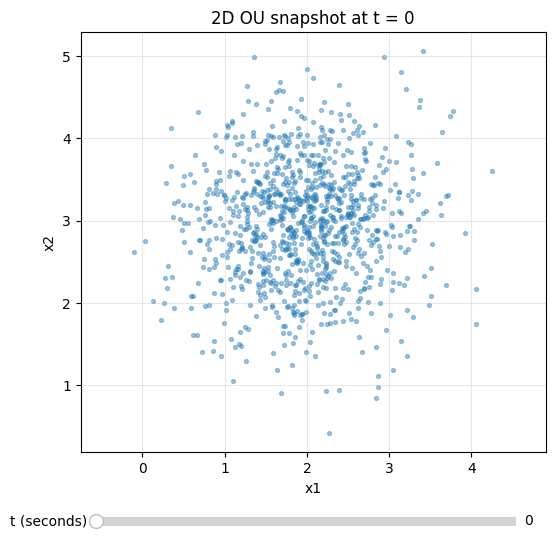

In [20]:
times, X_snap = interactive_ou_2d(
    beta=1.0,
    sigma=0.3,
    T_max=20.0,
    dt=0.01,
    mu0=np.array([2.0, 3.0]),   # 初始 mean，想改成 0 也可以
    C0=np.eye(2)*0.5,
    N=1000,
    seed=42
)
